# Notebook for Creating Figures from ResNet Activities Analysis Results

## Import Packages

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import pandas as pd
import pickle
from scipy import stats
import os
import seaborn as sns
import re
import random
import scipy

In [42]:
def open_pickle_file(filename, folder):
    with open(os.path.join(folder, filename), 'rb') as f:
        data = pickle.load(f)
    return data

## Style Settings

In [43]:
# Set color palettes
dark_green = '#006400'
dark_red = '#8b0000'
pal = {'Trained': dark_green, 'Untrained': dark_red}
light_green = '#90ee90'
light_red = '#ffcccb'
face_palette = sns.color_palette([light_green, light_red])
palette = sns.color_palette([dark_green, dark_red])

# Increase font size and thickness of axes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 2,
    'xtick.major.width': 2.5,
    'ytick.major.width': 2.5,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2,
    'xtick.major.size': 10,
    'ytick.major.size': 10,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5
})

In [44]:
# Significance annotation function
def add_stat_annotation(ax, x, y, data, hue, p_values):
    # Get the unique modules
    modules = data[x].unique()
    y_max = data[y].max()
    
    for module in modules:
        # Calculate positions for annotations
        trained_data = data[(data[x] == module) & (data[hue] == 'Trained')][y]
        untrained_data = data[(data[x] == module) & (data[hue] == 'Untrained')][y]
        y_min, y_max_trained = trained_data.min(), trained_data.max()
        y_min_untrained, y_max_untrained = untrained_data.min(), untrained_data.max()
        y_max_plot = max(y_max_trained, y_max_untrained)
        
        # Retrieve the p-value
        p_value = p_values[module]
        
        # Determine annotation text
        if p_value < 0.001:
            annotation = '***'
        elif p_value < 0.01:
            annotation = '**'
        elif p_value < 0.05:
            annotation = '*'
        else:
            annotation = 'ns'
        
        # Add the annotation
        ax.text(list(modules).index(module), y_max_plot + 0.01*y_max, annotation, 
                ha='center', va='bottom', color='black', fontsize=14, weight='bold')

In [45]:
def get_p_values(angles_trained_dict, angles_untrained_dict):
    p_values = {}

    for layer in angles_trained_dict.keys():
        trained_angles = angles_trained_dict[layer]
        untrained_angles = angles_untrained_dict[layer]
        
        print(f"\nComparing angles for module {layer}:")
        test_name, p_value = test_normality_and_compare(np.array(trained_angles), np.array(untrained_angles))
        
        if p_value < 0.05:
            print(f"Significant difference found in {layer} with {test_name}. P-value={p_value}")
        else:
            print(f"No significant difference found in {layer} with {test_name}. P-value={p_value}")
        
        p_values[layer] = p_value

    return p_values

def test_normality_and_compare(group1, group2):
    # Test for normality
    _, p_value_norm1 = stats.normaltest(group1)
    _, p_value_norm2 = stats.normaltest(group2)
    
    # If both groups are normally distributed (p > 0.05), use t-test
    if p_value_norm1 > 0.05 and p_value_norm2 > 0.05:
        _, p_value = stats.ttest_ind(group1, group2)
        test_name = "t-test"
    else:
        # If not normally distributed, use Mann-Whitney U test
        _, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        test_name = "Mann-Whitney U test"
    
    return test_name, p_value

In [46]:
def plot_angle_lineplot_ev(angles_trained_dict, angles_untrained_dict, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, x_ticks, pal, title, figsize=(12, 6), filepath=None, filename=None):
    # Set the style
    plt.style.use('default')
    sns.set_style("white")

    # Create a figure with dual axes
    fig, ax1 = plt.subplots(figsize=figsize)
    ax2 = ax1.twinx()

    # Prepare data for the line plot
    data = []
    for i, layer in enumerate(angles_trained_dict.keys()):
        data.append(pd.DataFrame({
            'Angle (degrees)': angles_trained_dict[layer],
            'Model': ['Trained'] * len(angles_trained_dict[layer]),
            'Module': [i] * len(angles_trained_dict[layer])
        }))
        data.append(pd.DataFrame({
            'Angle (degrees)': angles_untrained_dict[layer],
            'Model': ['Untrained'] * len(angles_untrained_dict[layer]),
            'Module': [i] * len(angles_untrained_dict[layer])
        }))
    data = pd.concat(data)

    # Plot angles on the primary y-axis
    sns.lineplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
                 linewidth=2, palette=pal, ax=ax1, errorbar='sd')

    # Plot SVD explained variance on the secondary y-axis
    x = range(len(x_ticks))
    ax2.plot(x, list(svd_ev_trained_weight.values()), color='darkgreen', linestyle=':', 
            alpha=0.7, linewidth=2, label='Trained SVD EV Weight')
    ax2.plot(x, list(svd_ev_untrained_weight.values()), color='darkred', linestyle=':', 
            alpha=0.7, linewidth=2, label='Untrained SVD EV Weight')
    ax2.plot(x, list(svd_ev_trained_activity.values()), color='blue', linestyle=':', 
            alpha=0.7, linewidth=2, label='Trained SVD EV Activity')
    ax2.plot(x, list(svd_ev_untrained_activity.values()), color='orange', linestyle=':', 
            alpha=0.7, linewidth=2, label='Untrained SVD EV Activity')

    # Customize the plot
    ax1.set_title(title, fontweight='bold', fontsize=14)
    ax1.set_ylabel('Angle (degrees)', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Resnet Layer', fontweight='bold', fontsize=12)
    ax1.set_xticks(range(len(x_ticks)))
    ax1.set_xticklabels(x_ticks, rotation=45, ha='right')
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.set_ylim([0, 95])

    ax2.set_ylabel('Explained Variance', fontweight='bold', fontsize=12, rotation=270, labelpad=15)
    ax2.set_ylim([0, 1.1])  # Set y-limit to 1.1 for the second axis
    ax2.tick_params(axis='y', labelsize=10)

    # Make tick labels bold
    for label in ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
        label.set_fontweight('bold')

    # Remove grid
    ax1.grid(False)
    ax2.grid(False)

    # Add bold spines
    for spine in ax1.spines.values():
        spine.set_linewidth(2)
    for spine in ax2.spines.values():
        spine.set_linewidth(2)

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model', title_fontsize='12', fontsize='10')

    plt.tight_layout()

    # Save the figure if filepath and filename are provided
    if filepath and filename:
        plt.savefig(f'{filepath}/{filename}.png', bbox_inches='tight', dpi=300)
    
    plt.show()

In [47]:
def plot_angle_boxplot_ev(angles_trained_dict, angles_untrained_dict, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, face_palette, title, figsize=(12, 8), filepath=None, filename=None):
    sns.set_style(style='white')
    fig, ax1 = plt.subplots(figsize=figsize)

    # Prepare data for the boxplot
    data = []
    for layer in angles_trained_dict.keys():
        data.append(pd.DataFrame({
            'Angle (degrees)': angles_trained_dict[layer],
            'Model': ['Trained'] * len(angles_trained_dict[layer]),
            'Module': [layer] * len(angles_trained_dict[layer])
        }))
        data.append(pd.DataFrame({
            'Angle (degrees)': angles_untrained_dict[layer],
            'Model': ['Untrained'] * len(angles_untrained_dict[layer]),
            'Module': [layer] * len(angles_untrained_dict[layer])
        }))
    data = pd.concat(data)

    # Create the boxplot with seaborn
    sns.boxplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
                boxprops={'edgecolor': 'k', 'linewidth': 2}, 
                medianprops={'color': 'k', 'linewidth': 2}, 
                whiskerprops={'color': 'k', 'linewidth': 2}, 
                capprops={'color': 'k', 'linewidth': 2}, 
                width=0.5, palette=face_palette, ax=ax1, dodge=True, showfliers=False)

    # Customize the plot
    ax1.set_title(title, weight='bold')
    ax1.set_ylabel('Angle (degrees)', weight='bold')
    ax1.set_xlabel('Resnet Layer', weight='bold')
    plt.xticks(ticks=np.arange(len(parsed_names)), labels=parsed_names, weight='bold')
    ax1.legend(title='Model', loc='upper left')
    plt.setp(ax1.get_yticklabels(), weight="bold")
    ax1.set_ylim([0, 95])

    # Create secondary y-axis for explained variance
    ax2 = ax1.twinx()
    
    # Set ylim based on the range of your EV data
    ax2.set_ylim([0, 1.1])

    # Create a mapping between parsed names and original layer names
    name_mapping = {parsed: full for parsed, full in zip(parsed_names, angles_trained_dict.keys())}

    # Filter and prepare data for plotting
    x_positions = np.arange(len(parsed_names))
    filtered_trained_weight = [svd_ev_trained_weight[name_mapping[name]] for name in parsed_names]
    filtered_untrained_weight = [svd_ev_untrained_weight[name_mapping[name]] for name in parsed_names]
    filtered_trained_activity = [svd_ev_trained_activity[name_mapping[name]] for name in parsed_names]
    filtered_untrained_activity = [svd_ev_untrained_activity[name_mapping[name]] for name in parsed_names]

    # Plot SVD explained variance for trained and untrained models with solid lines and larger markers
    ax2.plot(x_positions, filtered_trained_weight, color='darkgreen', linestyle='-', 
             marker='o', markersize=8, alpha=1, linewidth=2, label='Trained SVD EV Weight')
    ax2.plot(x_positions, filtered_untrained_weight, color='darkred', linestyle='-', 
             marker='s', markersize=8, alpha=1, linewidth=2, label='Untrained SVD EV Weight')

    ax2.plot(x_positions, filtered_trained_activity, color='blue', linestyle='-', 
             marker='^', markersize=8, alpha=1, linewidth=2, label='Trained SVD EV Activity')
    ax2.plot(x_positions, filtered_untrained_activity, color='orange', linestyle='-', 
             marker='D', markersize=8, alpha=1, linewidth=2, label='Untrained SVD EV Activity')

    ax2.set_ylabel('Explained Variance', weight='bold', rotation=270, labelpad=25)
    plt.setp(ax2.get_yticklabels(), weight="bold")

    # Add legend for all elements
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', title='Model')

    # Adjust the layout to prevent clipping
    plt.tight_layout()

    # Save the figure if filepath and filename are provided
    if filepath and filename:
        plt.savefig(f'{filepath}/{filename}.png', bbox_inches='tight', dpi=300)

    
    # add significance annotations
    p_values = get_p_values(angles_trained_dict, angles_untrained_dict)
    add_stat_annotation(ax1, 'Module', 'Angle (degrees)', data, 'Model', p_values)
    
    plt.show()

    # Print the data to verify
    print("Parsed names:", parsed_names)
    print("Trained Weight EV:", filtered_trained_weight)
    print("Untrained Weight EV:", filtered_untrained_weight)
    print("Trained Activity EV:", filtered_trained_activity)
    print("Untrained Activity EV:", filtered_untrained_activity)


In [48]:
def process_results_ev(all_data):
    """
    Process the results to generate combined angles for trained and untrained models,
    and separate SVD explained variances, averaged across all elements.
    """

    # Extract the individual dictionaries
    angles_trained_dict = all_data['angles_trained']
    angles_untrained_dict = all_data['angles_untrained']
    svd_ev_trained_dict = all_data['svd_explained_variances_trained']
    svd_ev_untrained_dict = all_data['svd_explained_variances_untrained']

    combined_angles_trained = {}
    combined_angles_untrained = {}

    svd_ev_trained_weight = {}
    svd_ev_untrained_weight = {}
    svd_ev_trained_activity = {}
    svd_ev_untrained_activity = {}

    for layer in angles_trained_dict.keys():
        trained_angles = angles_trained_dict[layer]
        untrained_angles = angles_untrained_dict[layer]
        trained_svd_ev = svd_ev_trained_dict.get(layer)
        untrained_svd_ev = svd_ev_untrained_dict.get(layer)

        # Combine all angles into one list for trained
        combined_angles_trained[layer] = []
        for angle_set in trained_angles:
            if isinstance(angle_set, list):
                for angle in angle_set:
                    combined_angles_trained[layer].extend(angle.flatten())
            elif isinstance(angle_set, np.ndarray):
                combined_angles_trained[layer].extend(angle_set.flatten())

        # Combine all angles into one list for untrained
        combined_angles_untrained[layer] = []
        for angle_set in untrained_angles:
            if isinstance(angle_set, list):
                for angle in angle_set:
                    combined_angles_untrained[layer].extend(angle.flatten())
            elif isinstance(angle_set, np.ndarray):
                combined_angles_untrained[layer].extend(angle_set.flatten())

        # Correctly handle the structure of the explained variance
        if trained_svd_ev:
            try:
                avg_weight_trained = np.mean([ev[0][0] for ev in trained_svd_ev])
                avg_activity_trained = np.mean([ev[0][1] for ev in trained_svd_ev])
                svd_ev_trained_weight[layer] = avg_weight_trained
                svd_ev_trained_activity[layer] = avg_activity_trained
            except IndexError:
                print(f"Error processing Trained SVD EV for layer {layer}. Data: {trained_svd_ev}")
        
        if untrained_svd_ev:
            try:
                avg_weight_untrained = np.mean([ev[0][0] for ev in untrained_svd_ev])
                avg_activity_untrained = np.mean([ev[0][1] for ev in untrained_svd_ev])
                svd_ev_untrained_weight[layer] = avg_weight_untrained
                svd_ev_untrained_activity[layer] = avg_activity_untrained
            except IndexError:
                print(f"Error processing Untrained SVD EV for layer {layer}. Data: {untrained_svd_ev}")

    return combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity


In [49]:
def combine_results_ev(downsample_data, conv1d_data):
    """
    Process and combine the results from branching downsample and conv1d operations.
    """
    # Process each dataset separately
    (combined_angles_trained_down, combined_angles_untrained_down, 
     svd_ev_trained_weight_down, svd_ev_untrained_weight_down, 
     svd_ev_trained_activity_down, svd_ev_untrained_activity_down) = process_results_ev(downsample_data)

    (combined_angles_trained_conv, combined_angles_untrained_conv, 
     svd_ev_trained_weight_conv, svd_ev_untrained_weight_conv, 
     svd_ev_trained_activity_conv, svd_ev_untrained_activity_conv) = process_results_ev(conv1d_data)

    # Merge the results
    combined_angles_trained = {**combined_angles_trained_down, **combined_angles_trained_conv}
    combined_angles_untrained = {**combined_angles_untrained_down, **combined_angles_untrained_conv}
    svd_ev_trained_weight = {**svd_ev_trained_weight_down, **svd_ev_trained_weight_conv}
    svd_ev_untrained_weight = {**svd_ev_untrained_weight_down, **svd_ev_untrained_weight_conv}
    svd_ev_trained_activity = {**svd_ev_trained_activity_down, **svd_ev_trained_activity_conv}
    svd_ev_untrained_activity = {**svd_ev_untrained_activity_down, **svd_ev_untrained_activity_conv}

    # Sort the combined dictionaries by layer names
    sorted_layers = sorted(combined_angles_trained.keys(), key=lambda x: (int(x.split('.')[0][5:]), int(x.split('.')[1])))
    
    combined_angles_trained = {k: combined_angles_trained[k] for k in sorted_layers}
    combined_angles_untrained = {k: combined_angles_untrained[k] for k in sorted_layers}
    svd_ev_trained_weight = {k: svd_ev_trained_weight[k] for k in sorted_layers}
    svd_ev_untrained_weight = {k: svd_ev_untrained_weight[k] for k in sorted_layers}
    svd_ev_trained_activity = {k: svd_ev_trained_activity[k] for k in sorted_layers}
    svd_ev_untrained_activity = {k: svd_ev_untrained_activity[k] for k in sorted_layers}

    return (combined_angles_trained, combined_angles_untrained, 
            svd_ev_trained_weight, svd_ev_untrained_weight, 
            svd_ev_trained_activity, svd_ev_untrained_activity)


In [50]:
def process_results_skip(all_data):
    """
    Process the results to generate combined angles for trained and untrained models,
    and separate SVD explained variances, averaged across all elements.
    Excludes layers containing '.0' in their names.
    """

    # Extract the individual dictionaries
    angles_trained_dict = all_data['angles_trained']
    angles_untrained_dict = all_data['angles_untrained']
    svd_ev_trained_dict = all_data['svd_explained_variances_trained']
    svd_ev_untrained_dict = all_data['svd_explained_variances_untrained']

    combined_angles_trained = {}
    combined_angles_untrained = {}

    svd_ev_trained_weight = {}
    svd_ev_untrained_weight = {}
    svd_ev_trained_activity = {}
    svd_ev_untrained_activity = {}

    for layer in angles_trained_dict.keys():
        # Skip layers containing '.0'
        if '.0' in layer:
            continue

        trained_angles = angles_trained_dict[layer]
        untrained_angles = angles_untrained_dict[layer]
        trained_svd_ev = svd_ev_trained_dict.get(layer)
        untrained_svd_ev = svd_ev_untrained_dict.get(layer)

        # Combine all angles into one list for trained
        combined_angles_trained[layer] = []
        for angle_set in trained_angles:
            if isinstance(angle_set, list):
                for angle in angle_set:
                    combined_angles_trained[layer].extend(angle.flatten())
            elif isinstance(angle_set, np.ndarray):
                combined_angles_trained[layer].extend(angle_set.flatten())

        # Combine all angles into one list for untrained
        combined_angles_untrained[layer] = []
        for angle_set in untrained_angles:
            if isinstance(angle_set, list):
                for angle in angle_set:
                    combined_angles_untrained[layer].extend(angle.flatten())
            elif isinstance(angle_set, np.ndarray):
                combined_angles_untrained[layer].extend(angle_set.flatten())

        # Correctly handle the structure of the explained variance
        if trained_svd_ev:
            try:
                avg_weight_trained = np.mean([ev[0][0] for ev in trained_svd_ev])
                avg_activity_trained = np.mean([ev[0][1] for ev in trained_svd_ev])
                svd_ev_trained_weight[layer] = avg_weight_trained
                svd_ev_trained_activity[layer] = avg_activity_trained
            except IndexError:
                print(f"Error processing Trained SVD EV for layer {layer}. Data: {trained_svd_ev}")

        if untrained_svd_ev:
            try:
                avg_weight_untrained = np.mean([ev[0][0] for ev in untrained_svd_ev])
                avg_activity_untrained = np.mean([ev[0][1] for ev in untrained_svd_ev])
                svd_ev_untrained_weight[layer] = avg_weight_untrained
                svd_ev_untrained_activity[layer] = avg_activity_untrained
            except IndexError:
                print(f"Error processing Untrained SVD EV for layer {layer}. Data: {untrained_svd_ev}")

    return combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity

In [51]:
def parse_names(names):
    parsed = []
    for name in names:
        parts = name.split('_to_')
        if len(parts) == 2:
            from_layer, to_layer = parts
            
            # Remove the ".conv3" suffix
            from_layer = from_layer.replace('.conv3', '')
            to_layer = to_layer.replace('.conv3', '')
            
            from_num = from_layer.split('layer')[-1]
            to_num = to_layer.split('layer')[-1]
            parsed.append(f"{from_num} → {to_num}")  # Using Unicode arrow (→) here
    return parsed

In [52]:
def parse_names_second_only(names):
    parsed = []
    for name in names:
        parts = name.split('_to_')
        if len(parts) == 2:
            from_layer, to_layer = parts
            
            # Remove the ".conv3" suffix
            from_layer = from_layer.replace('.conv3', '')
            to_layer = to_layer.replace('.conv3', '')
            
            from_num = from_layer.split('layer')[-1]
            to_num = to_layer.split('layer')[-1]
            parsed.append(f"{to_num}")  # Using Unicode arrow (→) here
    return parsed

In [53]:
folder = 'pickle'
long_skip_results = open_pickle_file('long_skip_results_single_image_n100_ev_svd_U_unroll.pkl', folder)
short_skip_results = open_pickle_file('short_skip_results_single_image_n100_ev_svd_U_unroll.pkl', folder)
indirect_results = open_pickle_file('indirect_results_single_image_n100_ev_svd_U_unroll.pkl', folder)
direct_results = open_pickle_file('direct_results_single_image_n100_ev_svd_U_unroll_conv3.pkl', folder)
direct_results_conv2 = open_pickle_file('direct_results_single_image_n100_ev_svd_U_unroll_conv2.pkl', folder)
direct_results_conv1 = open_pickle_file('direct_results_single_image_n100_ev_svd_U_unroll_conv1.pkl', folder)
branching_downsample_results = open_pickle_file('branching_downsample_results_single_image_n100_ev_svd_U_unroll.pkl', folder)
branching_conv1d_results = open_pickle_file('branching_conv1_results_single_image_n100_ev_svd_U_unroll.pkl', folder)




In [54]:
# function to save results of analysis to pickle file
def save_results(results, filename):
    pickle_folder = 'pickle'
    os.makedirs(pickle_folder, exist_ok=True)
    
    with open(os.path.join(pickle_folder, filename), 'wb') as f:
        pickle.dump(results, f)

# Plot angle distributions for example branching layer

In [55]:
def process_results_specific_layer(all_data, num_sets=10, specific_layer='layer1.0'):
    """
    Process the results to select a specified number of angle sets for a specific layer,
    preserving the structure of individual angle sets and including best combinations.
    """
    angles_trained_dict = all_data['angles_trained']
    angles_untrained_dict = all_data['angles_untrained']
    best_combinations_dict = all_data['best_combinations']

    selected_angles_trained = {}
    selected_angles_untrained = {}
    selected_best_combinations = {}

    if specific_layer in angles_trained_dict.keys():
        trained_angles = angles_trained_dict[specific_layer]
        untrained_angles = angles_untrained_dict[specific_layer]
        best_combinations = best_combinations_dict[specific_layer]

        # Select num_sets angle sets randomly
        selected_indices = random.sample(range(len(trained_angles)), min(num_sets, len(trained_angles)))
        
        selected_angles_trained[specific_layer] = [trained_angles[i][0] for i in selected_indices]  # Take the first (and only) element
        selected_angles_untrained[specific_layer] = [untrained_angles[i][0] for i in selected_indices]  # Take the first (and only) element
        selected_best_combinations[specific_layer] = [best_combinations[i][0] for i in selected_indices]  # Take the first (and only) element

    return selected_angles_trained, selected_angles_untrained, selected_best_combinations


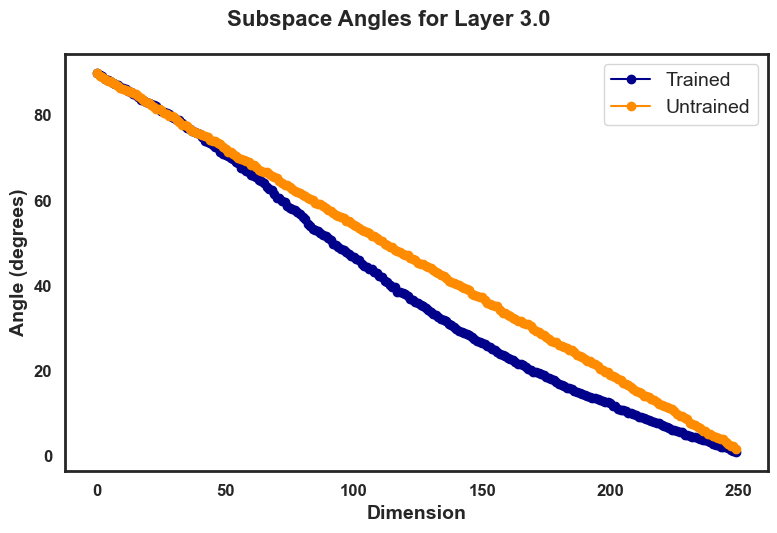

In [56]:
def plot_single_angle_distribution(layer_name, angle_index, selected_angles_trained, selected_angles_untrained, selected_best_combinations):
    # Extract the angle data for the specified layer
    angles_trained = selected_angles_trained[layer_name][angle_index]
    angles_untrained = selected_angles_untrained[layer_name][angle_index]
    row, col = selected_best_combinations[layer_name][angle_index]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle(f'Subspace Angles for Layer 3.0', y=.92, fontsize=16, fontweight='bold')
    
    ax.plot(np.arange(len(angles_trained)), angles_trained, label='Trained', marker='o', color='darkblue')
    ax.plot(np.arange(len(angles_untrained)), angles_untrained, label='Untrained', marker='o', color='darkorange')
    
    # ax.set_title(f'Set {angle_index + 1}: Rows={row}, Cols={col}')
    ax.set_ylabel('Angle (degrees)', fontweight='bold', fontsize=14)
    ax.set_xlabel('Dimension', fontweight='bold', fontsize=14)
    
    # Make x-ticks and y-ticks bold
    ax.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)
    plt.setp(ax.get_xticklabels(), fontweight='bold')
    plt.setp(ax.get_yticklabels(), fontweight='bold')
    
    ax.legend()
    ax.grid(False)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example usage
layer_name = 'layer3.0'  # Specify the layer
angle_index = 0  # Specify the angle index you want to plot

selected_angles_trained, selected_angles_untrained, selected_best_combinations = process_results_specific_layer(branching_downsample_results, specific_layer=layer_name)

plot_single_angle_distribution(layer_name, angle_index, selected_angles_trained, selected_angles_untrained, selected_best_combinations)



# Branching Results


Comparing angles for module layer1.0:
Significant difference found in layer1.0 with Mann-Whitney U test. P-value=9.65010910287527e-64

Comparing angles for module layer2.0:
Significant difference found in layer2.0 with Mann-Whitney U test. P-value=0.0

Comparing angles for module layer3.0:
Significant difference found in layer3.0 with Mann-Whitney U test. P-value=2.775082522697429e-201

Comparing angles for module layer4.0:
Significant difference found in layer4.0 with Mann-Whitney U test. P-value=0.0004170196535785478
Percentage difference in number of angles between trained and untrained: 0.11%
['layer1.0', 'layer2.0', 'layer3.0', 'layer4.0']
Number of trained angles: 90903
Number of untrained angles: 91004
['1.0', '2.0', '3.0', '4.0']

Comparing angles for module layer1.0:
Significant difference found in layer1.0 with Mann-Whitney U test. P-value=9.65010910287527e-64

Comparing angles for module layer2.0:
Significant difference found in layer2.0 with Mann-Whitney U test. P-value=0.

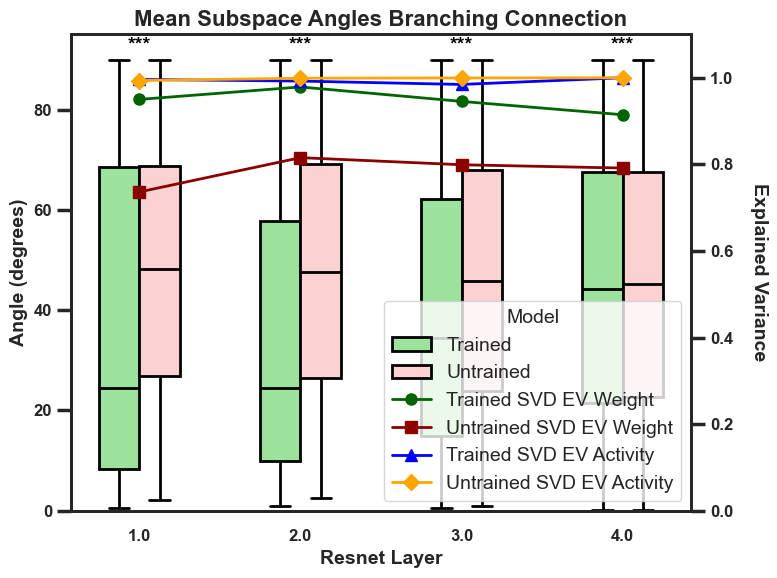

Parsed names: ['1.0', '2.0', '3.0', '4.0']
Trained Weight EV: [np.float32(0.95002174), np.float32(0.9787809), np.float32(0.9453878), np.float32(0.91461676)]
Untrained Weight EV: [np.float32(0.7362614), np.float32(0.81549835), np.float32(0.79905707), np.float32(0.79144824)]
Trained Activity EV: [np.float32(0.99609697), np.float32(0.99231225), np.float32(0.98460126), np.float32(1.0)]
Untrained Activity EV: [np.float32(0.9936161), np.float32(0.99893326), np.float32(0.999545), np.float32(1.0)]


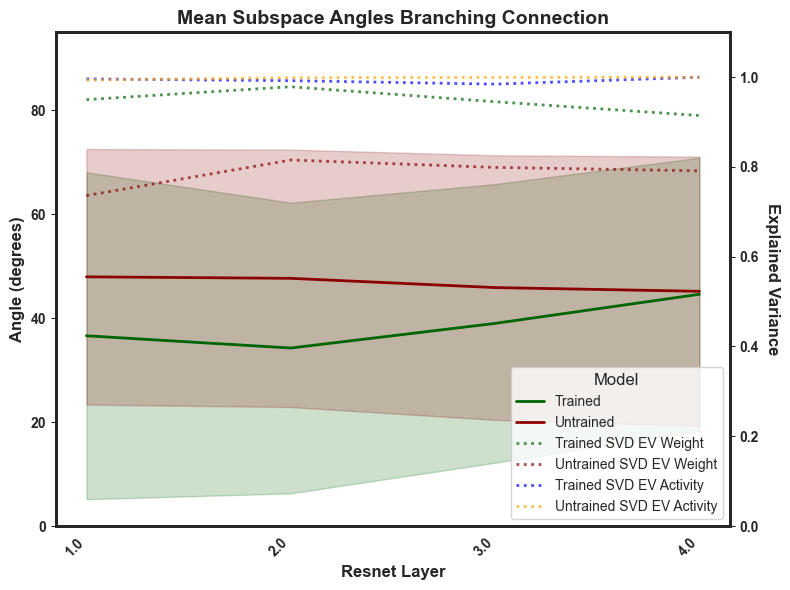

In [57]:
# Execute the function and print the results
combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity = process_results_ev(branching_downsample_results)
p_values = get_p_values(combined_angles_trained, combined_angles_untrained)
# print total number of angles in combined angles trained vs untrained
total_angles_trained = sum([len(angles) for angles in combined_angles_trained.values()])
total_angles_untrained = sum([len(angles) for angles in combined_angles_untrained.values()])

# print(f"Total number of angles in combined angles trained: {total_angles_trained}")
# print(f"Total number of angles in combined angles untrained: {total_angles_untrained}")
# print percentage difference of number of angles between trained and untrained
percentage_diff = ((total_angles_untrained - total_angles_trained) / total_angles_untrained) * 100
print(f"Percentage difference in number of angles between trained and untrained: {percentage_diff:.2f}%")
# print keys in angles_trained_dict
module_names = list(combined_angles_trained.keys())
print(module_names)

# print number of trained and untrained angles
trained_angles = [angle for angles in combined_angles_trained.values() for angle in angles]
untrained_angles = [angle for angles in combined_angles_untrained.values() for angle in angles]
print(f"Number of trained angles: {len(trained_angles)}")
print(f"Number of untrained angles: {len(untrained_angles)}")

# grab only from the 5th character onwards in the name
parsed_names = [name[5:] for name in module_names]
print(parsed_names)

title = 'Mean Subspace Angles Branching Connection'
plot_angle_boxplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, face_palette, title, figsize=(8, 6))
plot_angle_lineplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, palette, title, figsize=(8, 6))



Comparing angles for module layer1.0:
Significant difference found in layer1.0 with Mann-Whitney U test. P-value=9.137967716844158e-94

Comparing angles for module layer2.0:
Significant difference found in layer2.0 with Mann-Whitney U test. P-value=0.0

Comparing angles for module layer3.0:
Significant difference found in layer3.0 with Mann-Whitney U test. P-value=6.099760984294022e-274

Comparing angles for module layer4.0:
Significant difference found in layer4.0 with Mann-Whitney U test. P-value=0.0001555230211005941
Percentage difference in number of angles between trained and untrained: 0.12%
['layer1.0', 'layer2.0', 'layer3.0', 'layer4.0']
Number of trained angles: 81640
Number of untrained angles: 81740
['1.0', '2.0', '3.0', '4.0']

Comparing angles for module layer1.0:
Significant difference found in layer1.0 with Mann-Whitney U test. P-value=9.137967716844158e-94

Comparing angles for module layer2.0:
Significant difference found in layer2.0 with Mann-Whitney U test. P-value=

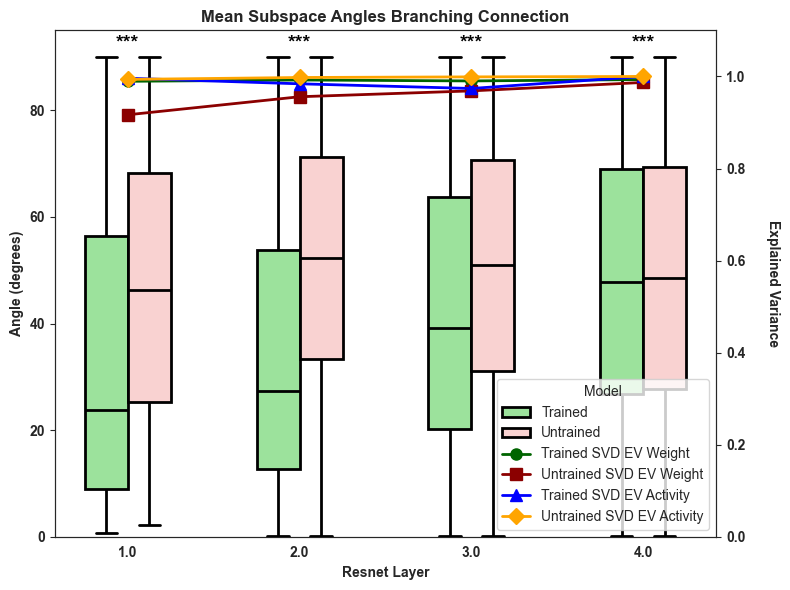

Parsed names: ['1.0', '2.0', '3.0', '4.0']
Trained Weight EV: [np.float32(0.9894928), np.float32(0.99235964), np.float32(0.9902866), np.float32(0.99331605)]
Untrained Weight EV: [np.float32(0.9167606), np.float32(0.9559421), np.float32(0.96867484), np.float32(0.9870284)]
Trained Activity EV: [np.float32(0.99609697), np.float32(0.98405755), np.float32(0.97390634), np.float32(1.0)]
Untrained Activity EV: [np.float32(0.9936161), np.float32(0.99777216), np.float32(0.99910843), np.float32(1.0)]


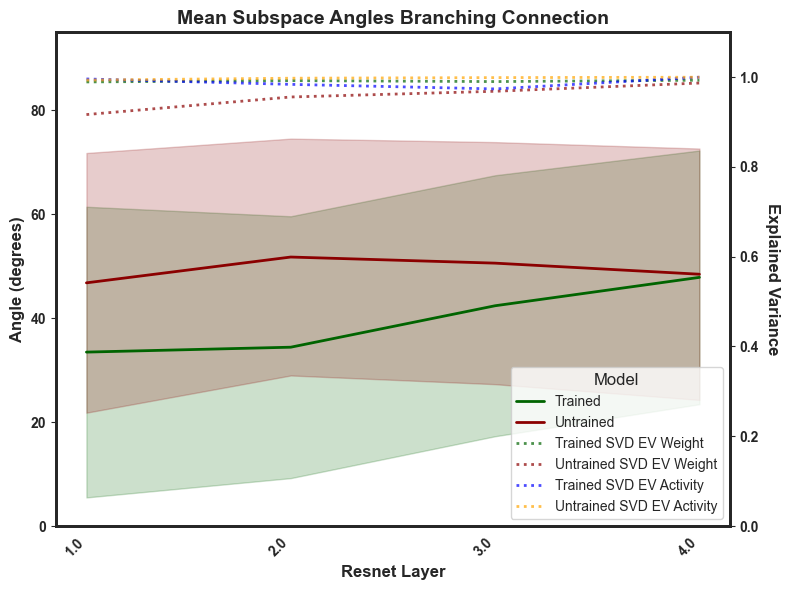

In [58]:
# Execute the function and print the results
combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity = process_results_ev(branching_conv1d_results)
p_values = get_p_values(combined_angles_trained, combined_angles_untrained)
# print total number of angles in combined angles trained vs untrained
total_angles_trained = sum([len(angles) for angles in combined_angles_trained.values()])
total_angles_untrained = sum([len(angles) for angles in combined_angles_untrained.values()])

# print(f"Total number of angles in combined angles trained: {total_angles_trained}")
# print(f"Total number of angles in combined angles untrained: {total_angles_untrained}")
# print percentage difference of number of angles between trained and untrained
percentage_diff = ((total_angles_untrained - total_angles_trained) / total_angles_untrained) * 100
print(f"Percentage difference in number of angles between trained and untrained: {percentage_diff:.2f}%")
# print keys in angles_trained_dict
module_names = list(combined_angles_trained.keys())
print(module_names)

# print number of trained and untrained angles
trained_angles = [angle for angles in combined_angles_trained.values() for angle in angles]
untrained_angles = [angle for angles in combined_angles_untrained.values() for angle in angles]
print(f"Number of trained angles: {len(trained_angles)}")
print(f"Number of untrained angles: {len(untrained_angles)}")

# grab only from the 5th character onwards in the name
parsed_names = [name[5:] for name in module_names]
print(parsed_names)

title = 'Mean Subspace Angles Branching Connection'
plot_angle_boxplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, face_palette, title, figsize=(8, 6))
plot_angle_lineplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, palette, title, figsize=(8, 6))



Comparing angles for module layer1.0:
Significant difference found in layer1.0 with Mann-Whitney U test. P-value=9.137967716844158e-94

Comparing angles for module layer2.0:
Significant difference found in layer2.0 with Mann-Whitney U test. P-value=0.0

Comparing angles for module layer3.0:
Significant difference found in layer3.0 with Mann-Whitney U test. P-value=6.099760984294022e-274

Comparing angles for module layer4.0:
Significant difference found in layer4.0 with Mann-Whitney U test. P-value=0.0001555230211005941
Percentage difference in number of angles between trained and untrained: 0.12%
['layer1.0', 'layer2.0', 'layer3.0', 'layer4.0']
Number of trained angles: 81640
Number of untrained angles: 81740
['1.0', '2.0', '3.0', '4.0']

Comparing angles for module layer1.0:
Significant difference found in layer1.0 with Mann-Whitney U test. P-value=9.137967716844158e-94

Comparing angles for module layer2.0:
Significant difference found in layer2.0 with Mann-Whitney U test. P-value=

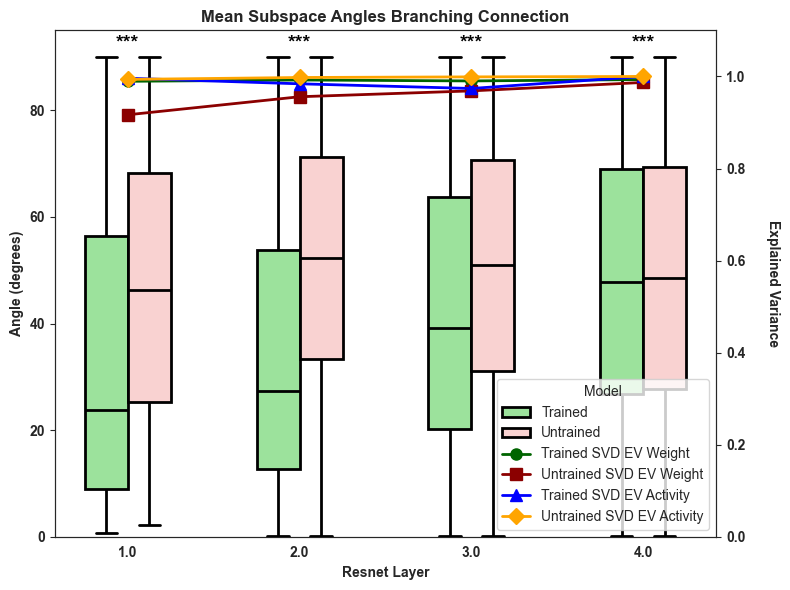

Parsed names: ['1.0', '2.0', '3.0', '4.0']
Trained Weight EV: [np.float32(0.9894928), np.float32(0.99235964), np.float32(0.9902866), np.float32(0.99331605)]
Untrained Weight EV: [np.float32(0.9167606), np.float32(0.9559421), np.float32(0.96867484), np.float32(0.9870284)]
Trained Activity EV: [np.float32(0.99609697), np.float32(0.98405755), np.float32(0.97390634), np.float32(1.0)]
Untrained Activity EV: [np.float32(0.9936161), np.float32(0.99777216), np.float32(0.99910843), np.float32(1.0)]


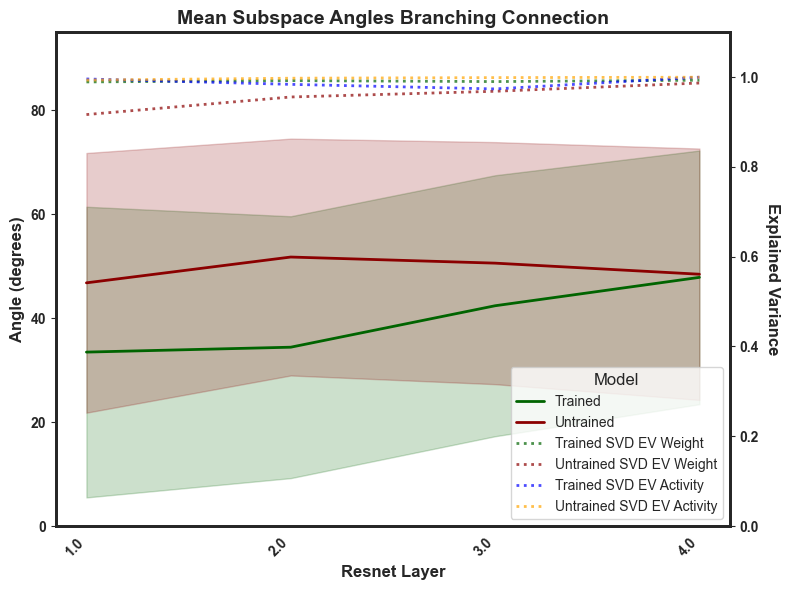

In [59]:
# combine branching downsample and branching conv1d results
(combined_angles_trained, combined_angles_untrained, 
 svd_ev_trained_weight, svd_ev_untrained_weight, 
 svd_ev_trained_activity, svd_ev_untrained_activity) = combine_results_ev(branching_downsample_results, branching_conv1d_results)

p_values = get_p_values(combined_angles_trained, combined_angles_untrained)
branching_p_values = p_values
# save the p_values to a pickle file
# save_results(p_values, 'acts-to-weights_branching_downsample_and_conv1d_p_values.pkl')
# print total number of angles in combined angles trained vs untrained
total_angles_trained = sum([len(angles) for angles in combined_angles_trained.values()])
total_angles_untrained = sum([len(angles) for angles in combined_angles_untrained.values()])

# print(f"Total number of angles in combined angles trained: {total_angles_trained}")
# print(f"Total number of angles in combined angles untrained: {total_angles_untrained}")
# print percentage difference of number of angles between trained and untrained
percentage_diff = ((total_angles_untrained - total_angles_trained) / total_angles_untrained) * 100
print(f"Percentage difference in number of angles between trained and untrained: {percentage_diff:.2f}%")
# print keys in angles_trained_dict
module_names = list(combined_angles_trained.keys())
print(module_names)

# print number of trained and untrained angles
trained_angles = [angle for angles in combined_angles_trained.values() for angle in angles]
untrained_angles = [angle for angles in combined_angles_untrained.values() for angle in angles]
print(f"Number of trained angles: {len(trained_angles)}")
print(f"Number of untrained angles: {len(untrained_angles)}")

# grab only from the 5th character onwards in the name
parsed_names = [name[5:] for name in module_names]
print(parsed_names)

title = 'Mean Subspace Angles Branching Connection'
plot_angle_boxplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, face_palette, title, figsize=(8, 6))
plot_angle_lineplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, palette, title, figsize=(8, 6))


# Direct Results


Comparing angles for module layer1.0:
Significant difference found in layer1.0 with Mann-Whitney U test. P-value=1.1383389059928242e-254

Comparing angles for module layer1.1:
Significant difference found in layer1.1 with Mann-Whitney U test. P-value=2.1543346365141382e-95

Comparing angles for module layer1.2:
Significant difference found in layer1.2 with Mann-Whitney U test. P-value=2.112475944555695e-31

Comparing angles for module layer2.0:
Significant difference found in layer2.0 with Mann-Whitney U test. P-value=3.7105065686220464e-154

Comparing angles for module layer2.1:
Significant difference found in layer2.1 with Mann-Whitney U test. P-value=1.6920152153647183e-207

Comparing angles for module layer2.2:
Significant difference found in layer2.2 with Mann-Whitney U test. P-value=2.0404515494705786e-186

Comparing angles for module layer2.3:
Significant difference found in layer2.3 with Mann-Whitney U test. P-value=5.286446739848019e-74

Comparing angles for module layer3.0:


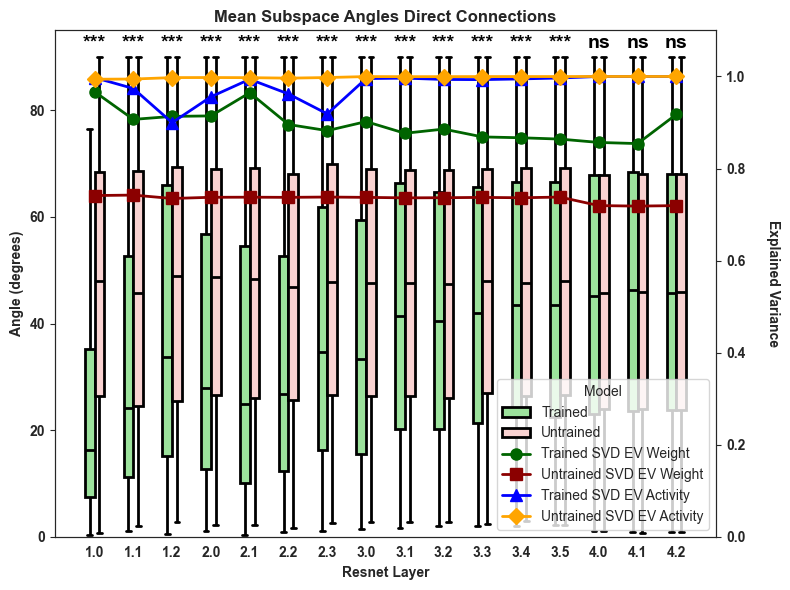

Parsed names: ['1.0', '1.1', '1.2', '2.0', '2.1', '2.2', '2.3', '3.0', '3.1', '3.2', '3.3', '3.4', '3.5', '4.0', '4.1', '4.2']
Trained Weight EV: [np.float32(0.9669119), np.float32(0.9067166), np.float32(0.91325784), np.float32(0.9143151), np.float32(0.9646244), np.float32(0.8956309), np.float32(0.8823269), np.float32(0.9019682), np.float32(0.87658286), np.float32(0.88568705), np.float32(0.8686735), np.float32(0.8667889), np.float32(0.86393964), np.float32(0.8566431), np.float32(0.854186), np.float32(0.9177372)]
Untrained Weight EV: [np.float32(0.7412981), np.float32(0.7422771), np.float32(0.734912), np.float32(0.7374846), np.float32(0.7376932), np.float32(0.73735374), np.float32(0.73803526), np.float32(0.7373219), np.float32(0.7362712), np.float32(0.7365759), np.float32(0.73722893), np.float32(0.7364959), np.float32(0.7379475), np.float32(0.7194359), np.float32(0.7183666), np.float32(0.7193938)]
Trained Activity EV: [np.float32(0.9975366), np.float32(0.9738781), np.float32(0.8996466),

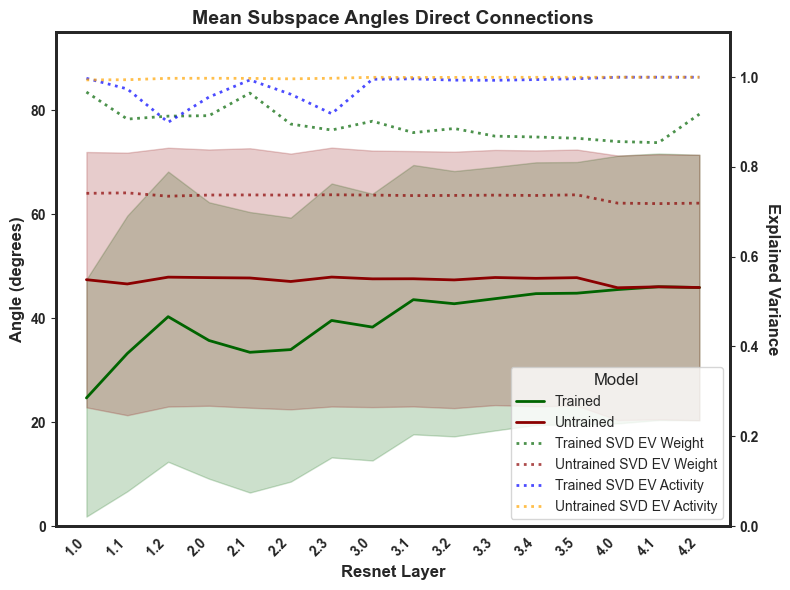

In [60]:
# Execute the function and print the results
combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity = process_results_ev(direct_results)
p_values = get_p_values(combined_angles_trained, combined_angles_untrained)
direct_p_values = p_values
# save the p_values to a pickle file
# save_results(p_values, 'acts-to-weights_direct_results_p_values.pkl')
# print total number of angles in combined angles trained vs untrained
total_angles_trained = sum([len(angles) for angles in combined_angles_trained.values()])
total_angles_untrained = sum([len(angles) for angles in combined_angles_untrained.values()])

# print(f"Total number of angles in combined angles trained: {total_angles_trained}")
# print(f"Total number of angles in combined angles untrained: {total_angles_untrained}")
# print percentage difference of number of angles between trained and untrained
percentage_diff = ((total_angles_untrained - total_angles_trained) / total_angles_untrained) * 100
print(f"Percentage difference in number of angles between trained and untrained: {percentage_diff:.2f}%")
# print keys in angles_trained_dict
module_names = list(combined_angles_trained.keys())
print(module_names)

# print number of trained and untrained angles
trained_angles = [angle for angles in combined_angles_trained.values() for angle in angles]
untrained_angles = [angle for angles in combined_angles_untrained.values() for angle in angles]
print(f"Number of trained angles: {len(trained_angles)}")
print(f"Number of untrained angles: {len(untrained_angles)}")

# grab only from the 5th character onwards in the name
parsed_names = [name[5:] for name in module_names]
print(parsed_names)

title = 'Mean Subspace Angles Direct Connections'
plot_angle_boxplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, face_palette, title, figsize=(8, 6))
plot_angle_lineplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, palette, title, figsize=(8, 6))


# Indirect Results


Comparing angles for module layer1.0.conv3_to_layer1.1.conv3:
No significant difference found in layer1.0.conv3_to_layer1.1.conv3 with Mann-Whitney U test. P-value=0.6047327725990461

Comparing angles for module layer1.1.conv3_to_layer1.2.conv3:
No significant difference found in layer1.1.conv3_to_layer1.2.conv3 with Mann-Whitney U test. P-value=0.6002828706408514

Comparing angles for module layer2.0.conv3_to_layer2.1.conv3:
No significant difference found in layer2.0.conv3_to_layer2.1.conv3 with Mann-Whitney U test. P-value=0.24224419591862412

Comparing angles for module layer2.1.conv3_to_layer2.2.conv3:
No significant difference found in layer2.1.conv3_to_layer2.2.conv3 with Mann-Whitney U test. P-value=0.10636203224163979

Comparing angles for module layer2.2.conv3_to_layer2.3.conv3:
No significant difference found in layer2.2.conv3_to_layer2.3.conv3 with Mann-Whitney U test. P-value=0.9063322408394592

Comparing angles for module layer3.0.conv3_to_layer3.1.conv3:
No significant 

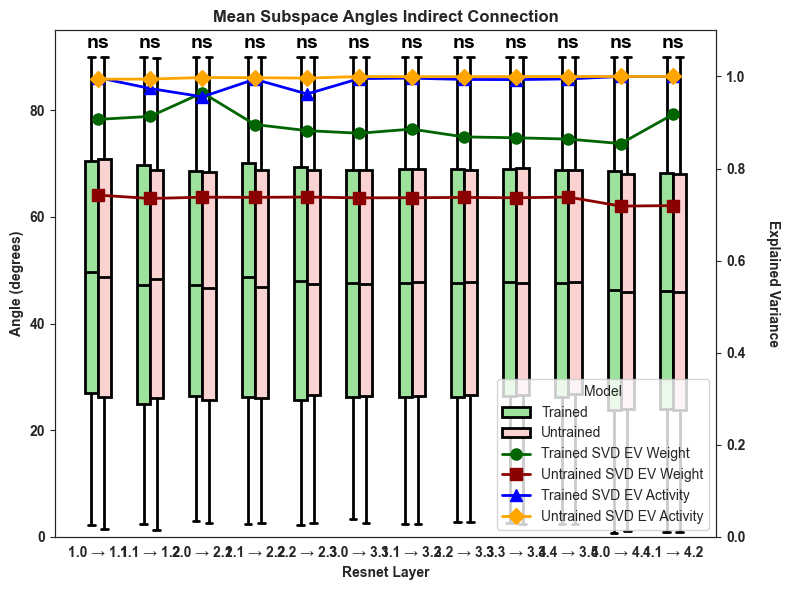

Parsed names: ['1.0 → 1.1', '1.1 → 1.2', '2.0 → 2.1', '2.1 → 2.2', '2.2 → 2.3', '3.0 → 3.1', '3.1 → 3.2', '3.2 → 3.3', '3.3 → 3.4', '3.4 → 3.5', '4.0 → 4.1', '4.1 → 4.2']
Trained Weight EV: [np.float32(0.9067166), np.float32(0.91325784), np.float32(0.9646244), np.float32(0.8956309), np.float32(0.8823269), np.float32(0.87658286), np.float32(0.88568705), np.float32(0.8686735), np.float32(0.8667889), np.float32(0.86393964), np.float32(0.854186), np.float32(0.9177372)]
Untrained Weight EV: [np.float32(0.7422771), np.float32(0.734912), np.float32(0.7376932), np.float32(0.73735374), np.float32(0.73803526), np.float32(0.7362712), np.float32(0.7365759), np.float32(0.73722893), np.float32(0.7364959), np.float32(0.7379475), np.float32(0.7183666), np.float32(0.7193938)]
Trained Activity EV: [np.float32(0.9975366), np.float32(0.9738781), np.float32(0.9558376), np.float32(0.99392706), np.float32(0.9620309), np.float32(0.995418), np.float32(0.9963711), np.float32(0.99350053), np.float32(0.99316406),

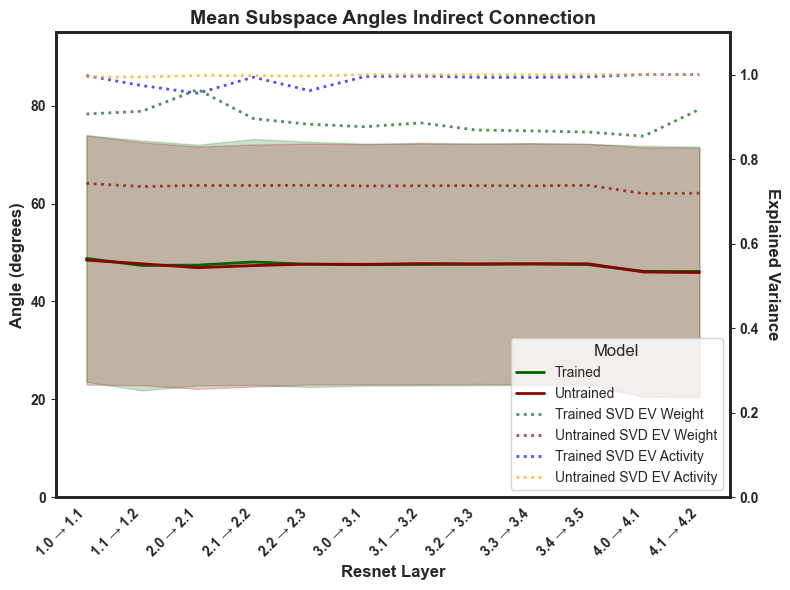

In [61]:
# Execute the function and print the results
combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity = process_results_ev(indirect_results)
p_values = get_p_values(combined_angles_trained, combined_angles_untrained)
indirect_p_values = p_values
# save the p_values to a pickle file
# save_results(p_values, 'acts-to-weights_indirect_results_p_values.pkl')
# print total number of angles in combined angles trained vs untrained
total_angles_trained = sum([len(angles) for angles in combined_angles_trained.values()])
total_angles_untrained = sum([len(angles) for angles in combined_angles_untrained.values()])

# print(f"Total number of angles in combined angles trained: {total_angles_trained}")
# print(f"Total number of angles in combined angles untrained: {total_angles_untrained}")
# print percentage difference of number of angles between trained and untrained
percentage_diff = ((total_angles_untrained - total_angles_trained) / total_angles_untrained) * 100
print(f"Percentage difference in number of angles between trained and untrained: {percentage_diff:.2f}%")
# print keys in angles_trained_dict
module_names = list(combined_angles_trained.keys())
print(module_names)

# print number of trained and untrained angles
trained_angles = [angle for angles in combined_angles_trained.values() for angle in angles]
untrained_angles = [angle for angles in combined_angles_untrained.values() for angle in angles]
print(f"Number of trained angles: {len(trained_angles)}")
print(f"Number of untrained angles: {len(untrained_angles)}")

# grab only from the 5th character onwards in the name
parsed_names = parse_names(module_names)
print(parsed_names)

title = 'Mean Subspace Angles Indirect Connection'
plot_angle_boxplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, face_palette, title, figsize=(8, 6))
plot_angle_lineplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, palette, title, figsize=(8, 6))


In [62]:
print(f'Indirect P-Values: {indirect_p_values}')

Indirect P-Values: {'layer1.0.conv3_to_layer1.1.conv3': np.float64(0.6047327725990461), 'layer1.1.conv3_to_layer1.2.conv3': np.float64(0.6002828706408514), 'layer2.0.conv3_to_layer2.1.conv3': np.float64(0.24224419591862412), 'layer2.1.conv3_to_layer2.2.conv3': np.float64(0.10636203224163979), 'layer2.2.conv3_to_layer2.3.conv3': np.float64(0.9063322408394592), 'layer3.0.conv3_to_layer3.1.conv3': np.float64(0.8480774263760021), 'layer3.1.conv3_to_layer3.2.conv3': np.float64(0.5802814324133643), 'layer3.2.conv3_to_layer3.3.conv3': np.float64(0.7562073341710825), 'layer3.3.conv3_to_layer3.4.conv3': np.float64(0.8336133895266162), 'layer3.4.conv3_to_layer3.5.conv3': np.float64(0.5937746967952299), 'layer4.0.conv3_to_layer4.1.conv3': np.float64(0.557659574522211), 'layer4.1.conv3_to_layer4.2.conv3': np.float64(0.30422054323953596)}


# Skip Connections


Comparing angles for module layer1.1:
Significant difference found in layer1.1 with Mann-Whitney U test. P-value=0.0

Comparing angles for module layer1.2:
Significant difference found in layer1.2 with Mann-Whitney U test. P-value=0.0

Comparing angles for module layer2.1:
Significant difference found in layer2.1 with Mann-Whitney U test. P-value=0.0

Comparing angles for module layer2.2:
Significant difference found in layer2.2 with Mann-Whitney U test. P-value=0.0

Comparing angles for module layer2.3:
Significant difference found in layer2.3 with Mann-Whitney U test. P-value=0.0

Comparing angles for module layer3.1:
Significant difference found in layer3.1 with Mann-Whitney U test. P-value=0.0

Comparing angles for module layer3.2:
Significant difference found in layer3.2 with Mann-Whitney U test. P-value=1.5364868685275214e-282

Comparing angles for module layer3.3:
Significant difference found in layer3.3 with Mann-Whitney U test. P-value=3.6973360355692305e-203

Comparing angle

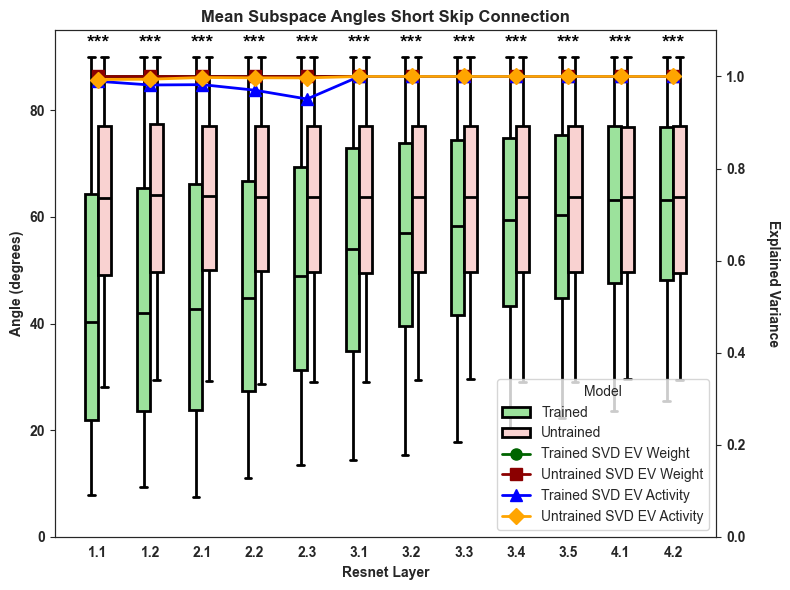

Parsed names: ['1.1', '1.2', '2.1', '2.2', '2.3', '3.1', '3.2', '3.3', '3.4', '3.5', '4.1', '4.2']
Trained Weight EV: [np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0)]
Untrained Weight EV: [np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0)]
Trained Activity EV: [np.float32(0.98955), np.float32(0.9814923), np.float32(0.9822128), np.float32(0.97019994), np.float32(0.95100486), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0)]
Untrained Activity EV: [np.float32(0.99341065), np.float32(0.99404055), np.float32(0.9977533), np.float32(0.9970446), np.float32(0.99693334), np.float32(1.0), np.float32(1.0), np.float32(1.0), np

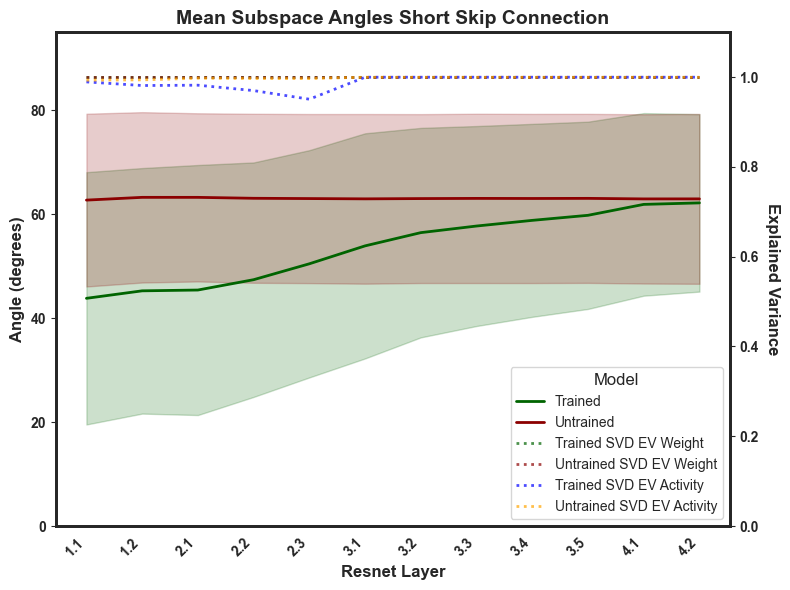

In [63]:
# Execute the function and print the results
combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity = process_results_skip(short_skip_results)

p_values = get_p_values(combined_angles_trained, combined_angles_untrained)
short_skip_p_values = p_values
# save the p_values to a pickle file
# save_results(p_values, 'acts-to-weights_short_skip_results_p_values.pkl')
# print total number of angles in combined angles trained vs untrained
total_angles_trained = sum([len(angles) for angles in combined_angles_trained.values()])
total_angles_untrained = sum([len(angles) for angles in combined_angles_untrained.values()])

# print(f"Total number of angles in combined angles trained: {total_angles_trained}")
# print(f"Total number of angles in combined angles untrained: {total_angles_untrained}")
# print percentage difference of number of angles between trained and untrained
percentage_diff = ((total_angles_untrained - total_angles_trained) / total_angles_untrained) * 100
print(f"Percentage difference in number of angles between trained and untrained: {percentage_diff:.2f}%")
# print keys in angles_trained_dict
module_names = list(combined_angles_trained.keys())
print(module_names)

# print number of trained and untrained angles
trained_angles = [angle for angles in combined_angles_trained.values() for angle in angles]
untrained_angles = [angle for angles in combined_angles_untrained.values() for angle in angles]
print(f"Number of trained angles: {len(trained_angles)}")
print(f"Number of untrained angles: {len(untrained_angles)}")

# grab only from the 5th character onwards in the name
parsed_names = [name[5:] for name in module_names]
print(parsed_names)

title = 'Mean Subspace Angles Short Skip Connection'
plot_angle_boxplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, face_palette, title, figsize=(8, 6))
plot_angle_lineplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, palette, title, figsize=(8, 6))


In [64]:
combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity = process_results_skip(long_skip_results)
# print keys for the layers
module_names = list(combined_angles_trained.keys())
print(module_names)

['layer1.1_to_layer1.2', 'layer2.1_to_layer2.2', 'layer2.2_to_layer2.3', 'layer3.1_to_layer3.2', 'layer3.2_to_layer3.3', 'layer3.3_to_layer3.4', 'layer3.4_to_layer3.5', 'layer4.1_to_layer4.2']



Comparing angles for module layer1.1_to_layer1.2:
Significant difference found in layer1.1_to_layer1.2 with Mann-Whitney U test. P-value=1.2120685338203274e-216

Comparing angles for module layer2.1_to_layer2.2:
Significant difference found in layer2.1_to_layer2.2 with Mann-Whitney U test. P-value=0.0

Comparing angles for module layer2.2_to_layer2.3:
Significant difference found in layer2.2_to_layer2.3 with Mann-Whitney U test. P-value=0.0

Comparing angles for module layer3.1_to_layer3.2:
Significant difference found in layer3.1_to_layer3.2 with Mann-Whitney U test. P-value=2.20462738416061e-234

Comparing angles for module layer3.2_to_layer3.3:
Significant difference found in layer3.2_to_layer3.3 with Mann-Whitney U test. P-value=6.601842607628365e-144

Comparing angles for module layer3.3_to_layer3.4:
Significant difference found in layer3.3_to_layer3.4 with Mann-Whitney U test. P-value=7.4542713431406385e-124

Comparing angles for module layer3.4_to_layer3.5:
Significant differen

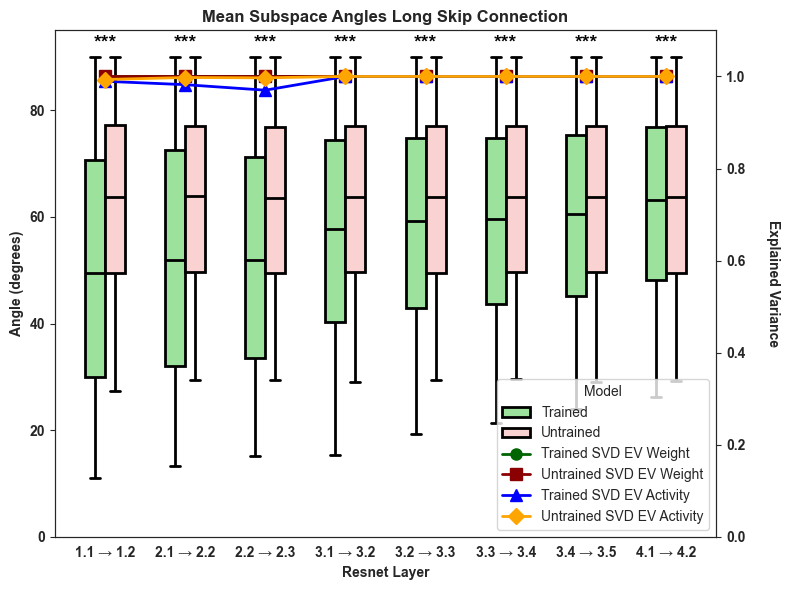

Parsed names: ['1.1 → 1.2', '2.1 → 2.2', '2.2 → 2.3', '3.1 → 3.2', '3.2 → 3.3', '3.3 → 3.4', '3.4 → 3.5', '4.1 → 4.2']
Trained Weight EV: [np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0)]
Untrained Weight EV: [np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0)]
Trained Activity EV: [np.float32(0.98955), np.float32(0.9822128), np.float32(0.97019994), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0)]
Untrained Activity EV: [np.float32(0.99341065), np.float32(0.9977533), np.float32(0.9970446), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0), np.float32(1.0)]


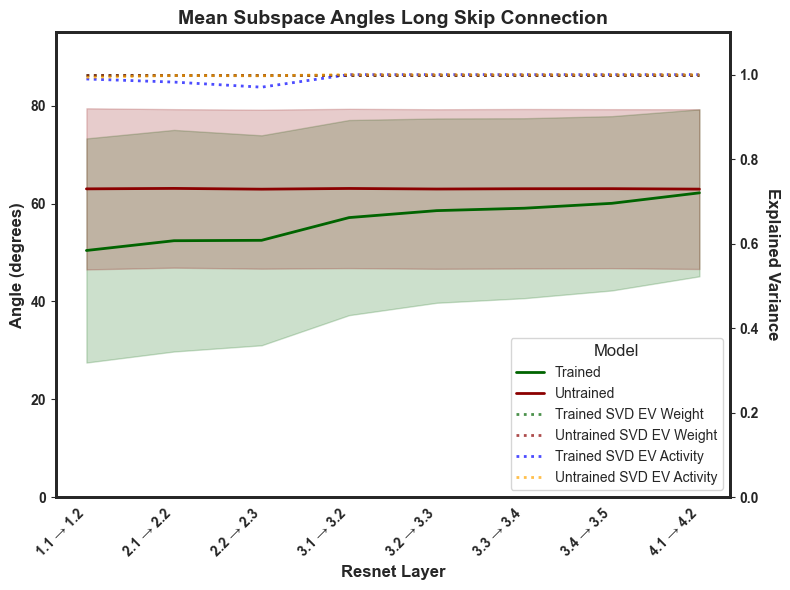

In [65]:
# Execute the function and print the results
combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity = process_results_skip(long_skip_results)

p_values = get_p_values(combined_angles_trained, combined_angles_untrained)
long_skip_p_values = p_values
# save the p_values to a pickle file
# save_results(p_values, 'acts-to-weights_long_skip_results_p_values.pkl')
# print total number of angles in combined angles trained vs untrained
total_angles_trained = sum([len(angles) for angles in combined_angles_trained.values()])
total_angles_untrained = sum([len(angles) for angles in combined_angles_untrained.values()])

# print(f"Total number of angles in combined angles trained: {total_angles_trained}")
# print(f"Total number of angles in combined angles untrained: {total_angles_untrained}")
# print percentage difference of number of angles between trained and untrained
percentage_diff = ((total_angles_untrained - total_angles_trained) / total_angles_untrained) * 100
print(f"Percentage difference in number of angles between trained and untrained: {percentage_diff:.2f}%")
# print keys in angles_trained_dict
module_names = list(combined_angles_trained.keys())
print(module_names)

# print number of trained and untrained angles
trained_angles = [angle for angles in combined_angles_trained.values() for angle in angles]
untrained_angles = [angle for angles in combined_angles_untrained.values() for angle in angles]
print(f"Number of trained angles: {len(trained_angles)}")
print(f"Number of untrained angles: {len(untrained_angles)}")

# grab only from the 5th character onwards in the name
parsed_names = parse_names(module_names)
print(f'parsed names: {parsed_names}')

title = 'Mean Subspace Angles Long Skip Connection'
plot_angle_boxplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, face_palette, title, figsize=(8, 6))
plot_angle_lineplot_ev(combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity, parsed_names, palette, title, figsize=(8, 6))


In [66]:
print(f'Long Skip P-Values {long_skip_p_values}')

Long Skip P-Values {'layer1.1_to_layer1.2': np.float64(1.2120685338203274e-216), 'layer2.1_to_layer2.2': np.float64(0.0), 'layer2.2_to_layer2.3': np.float64(0.0), 'layer3.1_to_layer3.2': np.float64(2.20462738416061e-234), 'layer3.2_to_layer3.3': np.float64(6.601842607628365e-144), 'layer3.3_to_layer3.4': np.float64(7.4542713431406385e-124), 'layer3.4_to_layer3.5': np.float64(1.8314237709291036e-74), 'layer4.1_to_layer4.2': np.float64(1.2034153718354753e-09)}


## P-Value Heatmap

In [67]:
# List of connection types and their corresponding p-values
connection_types = {
    'Direct': direct_p_values,
    'Branching': branching_p_values,
    'Shortskip': short_skip_p_values,
    'Longskip': long_skip_p_values,
    'Indirect': indirect_p_values

}

# Define the layer names to be included in the DataFrame
layers = [f'{i}.{j}' for i in range(1, 5) for j in range(3)]

# Initialize an empty DataFrame
df = pd.DataFrame(index=layers, columns=connection_types.keys())

# Populate the DataFrame
for conn_type, p_vals in connection_types.items():
    for layer in layers:
        layer_key = f'layer{layer}'
        layer_key_alt = f'{layer_key}.conv1'
        if layer_key in p_vals:
            df.at[layer, conn_type] = p_vals[layer_key]
        elif layer_key_alt in p_vals:
            df.at[layer, conn_type] = p_vals[layer_key_alt]
        else:
            df.at[layer, conn_type] = np.nan

# Display the DataFrame
print(df)

       Direct Branching Shortskip Longskip Indirect
1.0       0.0       0.0       NaN      NaN      NaN
1.1       0.0       NaN       0.0      NaN      NaN
1.2       0.0       NaN       0.0      NaN      NaN
2.0       0.0       0.0       NaN      NaN      NaN
2.1       0.0       NaN       0.0      NaN      NaN
2.2       0.0       NaN       0.0      NaN      NaN
3.0       0.0       0.0       NaN      NaN      NaN
3.1       0.0       NaN       0.0      NaN      NaN
3.2       0.0       NaN       0.0      NaN      NaN
4.0  0.130098  0.000156       NaN      NaN      NaN
4.1   0.97235       NaN       0.0      NaN      NaN
4.2  0.986385       NaN       0.0      NaN      NaN


In [68]:
# List of connection types and their corresponding p-values
connection_types = {
    'Direct': direct_p_values,
    'Branching': branching_p_values,
    'Shortskip': short_skip_p_values,
    'Longskip': long_skip_p_values,
    'Indirect': indirect_p_values
}

# Define the layer names to be included in the DataFrame
layers = [f'{i}.{j}' for i in range(1, 5) for j in range(3)]

# Initialize an empty DataFrame
df = pd.DataFrame(index=layers, columns=connection_types.keys())

# Function to extract the first two numbers and the period from complex layer names
def extract_layer_name(complex_name, conn_type):
    if conn_type in ['Longskip']:
        # For Longskip, assume the format is 'layerX.Y_to_layerA.B' and extract 'X.Y'
        return complex_name.split('_')[0].replace('layer', '')
    elif conn_type in ['Indirect']:
        # For Indirect, assume the format is 'layerX.Y.conv3_to_layerA.B.conv3' and extract 'X.Y'
        return complex_name.split('_')[0].replace('layer', '').replace('.conv3', '')
    else:
        # Default extraction
        return complex_name

# Populate the DataFrame
for conn_type, p_vals in connection_types.items():
    for layer in layers:
        # For Indirect and Longskip connections, parse the name differently
        if conn_type in ['Indirect', 'Longskip']:
            matched = False
            for key in p_vals:
                if extract_layer_name(key, conn_type) == layer:
                    df.at[layer, conn_type] = p_vals[key]
                    matched = True
                    break
            if not matched:
                df.at[layer, conn_type] = np.nan
        else:
            # For other connections, use the original key format
            layer_key = f'layer{layer}'
            layer_key_alt = f'{layer_key}.conv1'
            if layer_key in p_vals:
                df.at[layer, conn_type] = p_vals[layer_key]
            elif layer_key_alt in p_vals:
                df.at[layer, conn_type] = p_vals[layer_key_alt]
            else:
                df.at[layer, conn_type] = np.nan

# Display the DataFrame
print(df)



       Direct Branching Shortskip Longskip  Indirect
1.0       0.0       0.0       NaN      NaN  0.604733
1.1       0.0       NaN       0.0      0.0  0.600283
1.2       0.0       NaN       0.0      NaN       NaN
2.0       0.0       0.0       NaN      NaN  0.242244
2.1       0.0       NaN       0.0      0.0  0.106362
2.2       0.0       NaN       0.0      0.0  0.906332
3.0       0.0       0.0       NaN      NaN  0.848077
3.1       0.0       NaN       0.0      0.0  0.580281
3.2       0.0       NaN       0.0      0.0  0.756207
4.0  0.130098  0.000156       NaN      NaN   0.55766
4.1   0.97235       NaN       0.0      0.0  0.304221
4.2  0.986385       NaN       0.0      NaN       NaN


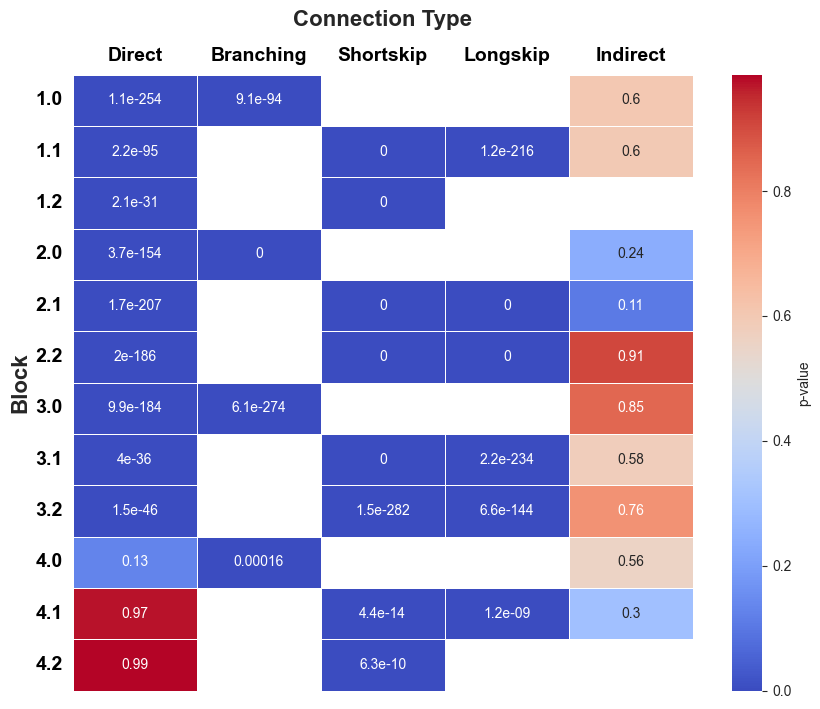

In [69]:
# Convert the DataFrame to float, replacing NaNs with a placeholder (e.g., np.nan)
df_float = df.astype(float)

# Create a heatmap of the DataFrame
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_float, annot=True, cmap='coolwarm', cbar_kws={'label': 'p-value'}, linewidths=.5)

# Move x-axis labels to the top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

# Set the axis labels and title with bold and larger font size
plt.xlabel('Connection Type', fontsize=16, fontweight='bold', labelpad=15)
plt.ylabel('Block', fontsize=16, fontweight='bold')

# Customize the tick labels with bold font and larger size
ax.tick_params(axis='x', labelsize=14, width=0, labelrotation=0, labelcolor='black', labelbottom=False, labeltop=True)
ax.tick_params(axis='y', labelsize=14, labelrotation=0, labelcolor='black')

# Manually set the fontweight for tick labels
for tick in ax.get_xticklabels():
    tick.set_fontsize(14)
    tick.set_fontweight('bold')

for tick in ax.get_yticklabels():
    tick.set_fontsize(14)
    tick.set_fontweight('bold')

# Remove the lines connecting the xtick labels to the columns
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the heatmap
plt.show()

# Only graphing means

In [70]:
def process_results_ev(all_data):
    """
    Parameters: results of the analysis in the form of 
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'svd_explained_variances_trained': {},
        'svd_explained_variances_untrained': {}
    }

    Outputs:
    - mean_angles_trained: Dictionary containing 500 mean angles for each trained layer
    - mean_angles_untrained: Dictionary containing 500 mean angles for each untrained layer
    - svd_ev_trained_weight: Dictionary containing the average SVD explained variances for weights in trained layers
    - svd_ev_untrained_weight: Dictionary containing the average SVD explained variances for weights in untrained layers
    - svd_ev_trained_activity: Dictionary containing the average SVD explained variances for activities in trained layers
    - svd_ev_untrained_activity: Dictionary containing the average SVD explained variances for activities in untrained layers
    """
    
    # Extract the individual dictionaries
    angles_trained_dict = all_data['angles_trained']
    angles_untrained_dict = all_data['angles_untrained']
    svd_ev_trained_dict = all_data['svd_explained_variances_trained']
    svd_ev_untrained_dict = all_data['svd_explained_variances_untrained']

    mean_angles_trained = {}
    mean_angles_untrained = {}

    svd_ev_trained_weight = {}
    svd_ev_untrained_weight = {}
    svd_ev_trained_activity = {}
    svd_ev_untrained_activity = {}

    for layer in angles_trained_dict.keys():
        trained_angles = angles_trained_dict[layer]
        untrained_angles = angles_untrained_dict[layer]
        trained_svd_ev = svd_ev_trained_dict.get(layer)
        untrained_svd_ev = svd_ev_untrained_dict.get(layer)
        
        # Calculate mean angles for trained (500 means)
        mean_angles_trained[layer] = [
            np.mean(angle_set) if isinstance(angle_set, np.ndarray)
            else np.mean(angle_set[0]) if isinstance(angle_set, list) and len(angle_set) > 0
            else angle_set
            for angle_set in trained_angles
        ]
        
        # Calculate mean angles for untrained (500 means)
        mean_angles_untrained[layer] = [
            np.mean(angle_set) if isinstance(angle_set, np.ndarray)
            else np.mean(angle_set[0]) if isinstance(angle_set, list) and len(angle_set) > 0
            else angle_set
            for angle_set in untrained_angles
        ]

        # Handle the structure of the explained variance
        if trained_svd_ev:
            try:
                avg_weight_trained = np.mean([ev[0][0] for ev in trained_svd_ev])
                avg_activity_trained = np.mean([ev[0][1] for ev in trained_svd_ev])
                svd_ev_trained_weight[layer] = avg_weight_trained
                svd_ev_trained_activity[layer] = avg_activity_trained
            except IndexError:
                print(f"Error processing Trained SVD EV for layer {layer}. Data: {trained_svd_ev}")
        
        if untrained_svd_ev:
            try:
                avg_weight_untrained = np.mean([ev[0][0] for ev in untrained_svd_ev])
                avg_activity_untrained = np.mean([ev[0][1] for ev in untrained_svd_ev])
                svd_ev_untrained_weight[layer] = avg_weight_untrained
                svd_ev_untrained_activity[layer] = avg_activity_untrained
            except IndexError:
                print(f"Error processing Untrained SVD EV for layer {layer}. Data: {untrained_svd_ev}")

    return mean_angles_trained, mean_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity

In [71]:
def process_results_skip(all_data):
    """
    Parameters: results of the analysis in the form of 
    results = {
        'best_combinations': {},
        'angles_trained': {},
        'angles_untrained': {},
        'layer_names': {},
        'svd_explained_variances_trained': {},
        'svd_explained_variances_untrained': {}
    }

    Outputs:
    - mean_angles_trained: Dictionary containing 500 mean angles for each trained layer
    - mean_angles_untrained: Dictionary containing 500 mean angles for each untrained layer
    - svd_ev_trained_weight: Dictionary containing the average SVD explained variances for weights in trained layers
    - svd_ev_untrained_weight: Dictionary containing the average SVD explained variances for weights in untrained layers
    - svd_ev_trained_activity: Dictionary containing the average SVD explained variances for activities in trained layers
    - svd_ev_untrained_activity: Dictionary containing the average SVD explained variances for activities in untrained layers
    """
    
    # Extract the individual dictionaries
    angles_trained_dict = all_data['angles_trained']
    angles_untrained_dict = all_data['angles_untrained']
    svd_ev_trained_dict = all_data['svd_explained_variances_trained']
    svd_ev_untrained_dict = all_data['svd_explained_variances_untrained']

    mean_angles_trained = {}
    mean_angles_untrained = {}

    svd_ev_trained_weight = {}
    svd_ev_untrained_weight = {}
    svd_ev_trained_activity = {}
    svd_ev_untrained_activity = {}

    for layer in angles_trained_dict.keys():
        # Skip layers containing '.0'
        if '.0' in layer:
            continue

        trained_angles = angles_trained_dict[layer]
        untrained_angles = angles_untrained_dict[layer]
        trained_svd_ev = svd_ev_trained_dict.get(layer)
        untrained_svd_ev = svd_ev_untrained_dict.get(layer)
        
        # Calculate mean angles for trained (500 means)
        mean_angles_trained[layer] = [
            np.mean(angle_set) if isinstance(angle_set, np.ndarray)
            else np.mean(angle_set[0]) if isinstance(angle_set, list) and len(angle_set) > 0
            else angle_set
            for angle_set in trained_angles
        ]
        
        # Calculate mean angles for untrained (500 means)
        mean_angles_untrained[layer] = [
            np.mean(angle_set) if isinstance(angle_set, np.ndarray)
            else np.mean(angle_set[0]) if isinstance(angle_set, list) and len(angle_set) > 0
            else angle_set
            for angle_set in untrained_angles
        ]

        # Handle the structure of the explained variance
        if trained_svd_ev:
            try:
                avg_weight_trained = np.mean([ev[0][0] for ev in trained_svd_ev])
                avg_activity_trained = np.mean([ev[0][1] for ev in trained_svd_ev])
                svd_ev_trained_weight[layer] = avg_weight_trained
                svd_ev_trained_activity[layer] = avg_activity_trained
            except IndexError:
                print(f"Error processing Trained SVD EV for layer {layer}. Data: {trained_svd_ev}")
        
        if untrained_svd_ev:
            try:
                avg_weight_untrained = np.mean([ev[0][0] for ev in untrained_svd_ev])
                avg_activity_untrained = np.mean([ev[0][1] for ev in untrained_svd_ev])
                svd_ev_untrained_weight[layer] = avg_weight_untrained
                svd_ev_untrained_activity[layer] = avg_activity_untrained
            except IndexError:
                print(f"Error processing Untrained SVD EV for layer {layer}. Data: {untrained_svd_ev}")

    return mean_angles_trained, mean_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity

In [72]:
blue = '#1f77b4'

palette = sns.color_palette([blue, dark_red])

def plot_angle_lineplot(mean_angles_trained, mean_angles_untrained, 
                           parsed_names, face_palette, title, 
                           figsize=(12, 6), filepath=None, filename=None):
    # Set the style
    plt.style.use('default')
    sns.set_style("white")

    # Create a figure
    fig, ax1 = plt.subplots(figsize=figsize)

    # Prepare data for the line plot
    data = []
    for i, layer in enumerate(mean_angles_trained.keys()):
        data.append(pd.DataFrame({
            'Mean Angle (degrees)': mean_angles_trained[layer],
            'Model': ['Trained'] * len(mean_angles_trained[layer]),
            'Module': [i] * len(mean_angles_trained[layer])
        }))
        data.append(pd.DataFrame({
            'Mean Angle (degrees)': mean_angles_untrained[layer],
            'Model': ['Untrained'] * len(mean_angles_untrained[layer]),
            'Module': [i] * len(mean_angles_untrained[layer])
        }))
    data = pd.concat(data)

    # Plot angles on the primary y-axis
    sns.lineplot(x='Module', y='Mean Angle (degrees)', hue='Model', data=data,
                 linewidth=2, palette=face_palette, ax=ax1, errorbar='sd', legend=True)

    # Customize the plot
    # ax1.set_title(title, fontweight='bold', fontsize=20)
    ax1.set_ylabel('Angle (Degrees)', fontweight='bold', fontsize=16)
    ax1.set_xlabel('Resnet Layer', fontweight='bold', fontsize=16)
    ax1.set_xticks(range(len(parsed_names)))
    ax1.set_xticklabels(parsed_names, rotation=45, ha='right')
    # ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.set_ylim([15, 70])


    # Make tick labels bold
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold'), label.set_fontsize(14)

    # Make tick labels bold
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold'), label.set_fontsize(16)

    # Remove grid
    ax1.grid(False)

    # Add bold spines
    for spine in ax1.spines.values():
        spine.set_linewidth(2)

    # # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    ax1.legend(lines1, labels1, loc='upper right', title='Model', title_fontsize='14', fontsize='12')

    plt.tight_layout()

    # Save the figure if filepath and filename are provided
    if filepath and filename:
        plt.savefig(f'{filepath}/{filename}.png', bbox_inches='tight', dpi=300)
    
    plt.show()


['layer1.1_to_layer1.2', 'layer2.1_to_layer2.2', 'layer2.2_to_layer2.3', 'layer3.1_to_layer3.2', 'layer3.2_to_layer3.3', 'layer3.3_to_layer3.4', 'layer3.4_to_layer3.5', 'layer4.1_to_layer4.2']
['1.2', '2.2', '2.3', '3.2', '3.3', '3.4', '3.5', '4.2']


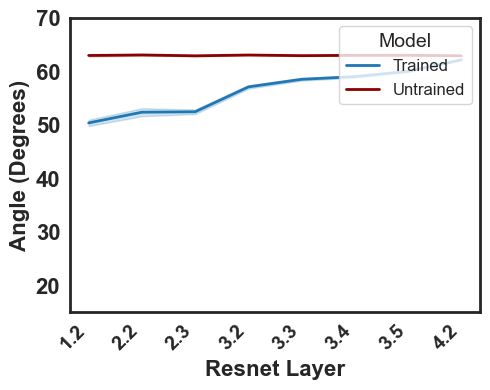

In [73]:
combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity = process_results_skip(long_skip_results)
# print keys in angles_trained_dict
module_names = list(combined_angles_trained.keys())
print(module_names)

# get the nubmer of trained and untrained angles
trained_angles = [angle for angles in combined_angles_trained.values() for angle in angles]

# grab only from the 5th character onwards in the name
parsed_names = parse_names_second_only(module_names)
print(parsed_names)

title = 'Mean Subspace Angles Long Skip Connection'

plot_angle_lineplot(combined_angles_trained, combined_angles_untrained,  
                           parsed_names, palette, title, 
                           figsize=(5, 4), filepath=None, filename=None)

['layer1.1', 'layer1.2', 'layer2.1', 'layer2.2', 'layer2.3', 'layer3.1', 'layer3.2', 'layer3.3', 'layer3.4', 'layer3.5', 'layer4.1', 'layer4.2']
['1.1', '1.2', '2.1', '2.2', '2.3', '3.1', '3.2', '3.3', '3.4', '3.5', '4.1', '4.2']


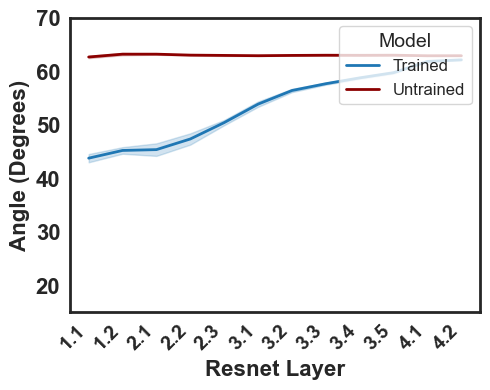

In [74]:
combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity = process_results_skip(short_skip_results)
# print keys in angles_trained_dict
module_names = list(combined_angles_trained.keys())
print(module_names)

# get the nubmer of trained and untrained angles
trained_angles = [angle for angles in combined_angles_trained.values() for angle in angles]

# grab only from the 5th character onwards in the name
parsed_names = [name[5:] for name in module_names]
print(parsed_names)

title = 'Mean Subspace Angles Short Skip Connection'

plot_angle_lineplot(combined_angles_trained, combined_angles_untrained,  
                           parsed_names, palette, title, 
                           figsize=(5, 4), filepath=None, filename=None)

['layer1.0', 'layer1.1', 'layer1.2', 'layer2.0', 'layer2.1', 'layer2.2', 'layer2.3', 'layer3.0', 'layer3.1', 'layer3.2', 'layer3.3', 'layer3.4', 'layer3.5', 'layer4.0', 'layer4.1', 'layer4.2']
['1.0', '1.1', '1.2', '2.0', '2.1', '2.2', '2.3', '3.0', '3.1', '3.2', '3.3', '3.4', '3.5', '4.0', '4.1', '4.2']


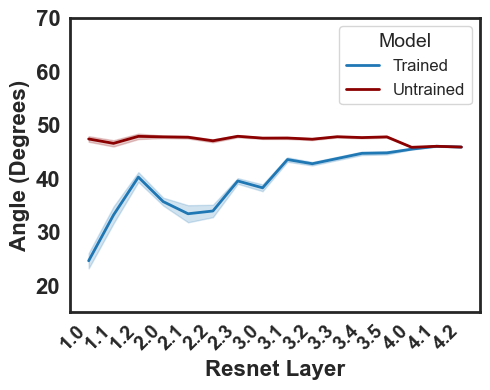

In [75]:
combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity = process_results_ev(direct_results)
# print keys in angles_trained_dict
module_names = list(combined_angles_trained.keys())
print(module_names)

# get the nubmer of trained and untrained angles
trained_angles = [angle for angles in combined_angles_trained.values() for angle in angles]

# grab only from the 5th character onwards in the name
parsed_names = [name[5:] for name in module_names]
print(parsed_names)

title = 'Mean Subspace Angles Direct Connection'

plot_angle_lineplot(combined_angles_trained, combined_angles_untrained,  
                           parsed_names, palette, title, 
                           figsize=(5, 4), filepath=None, filename=None)

['layer1.0.conv3_to_layer1.1.conv3', 'layer1.1.conv3_to_layer1.2.conv3', 'layer2.0.conv3_to_layer2.1.conv3', 'layer2.1.conv3_to_layer2.2.conv3', 'layer2.2.conv3_to_layer2.3.conv3', 'layer3.0.conv3_to_layer3.1.conv3', 'layer3.1.conv3_to_layer3.2.conv3', 'layer3.2.conv3_to_layer3.3.conv3', 'layer3.3.conv3_to_layer3.4.conv3', 'layer3.4.conv3_to_layer3.5.conv3', 'layer4.0.conv3_to_layer4.1.conv3', 'layer4.1.conv3_to_layer4.2.conv3']
['1.1', '1.2', '2.1', '2.2', '2.3', '3.1', '3.2', '3.3', '3.4', '3.5', '4.1', '4.2']


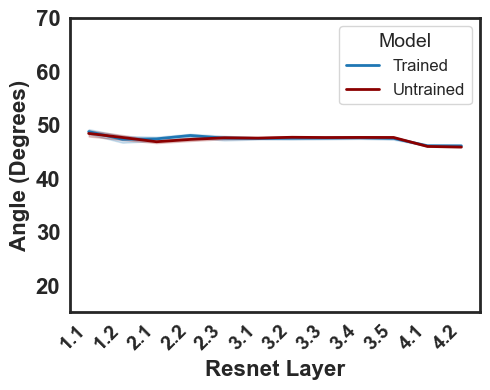

In [76]:
combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity = process_results_ev(indirect_results)
# print keys in angles_trained_dict
module_names = list(combined_angles_trained.keys())
print(module_names)

# get the nubmer of trained and untrained angles
trained_angles = [angle for angles in combined_angles_trained.values() for angle in angles]

# grab only from the 5th character onwards in the name
parsed_names = parse_names_second_only(module_names)
print(parsed_names)

title = 'Mean Subspace Angles Indirect Connection'

plot_angle_lineplot(combined_angles_trained, combined_angles_untrained,  
                           parsed_names, palette, title, 
                           figsize=(5, 4), filepath=None, filename=None)

['layer1.0', 'layer2.0', 'layer3.0', 'layer4.0']
['1.0', '2.0', '3.0', '4.0']


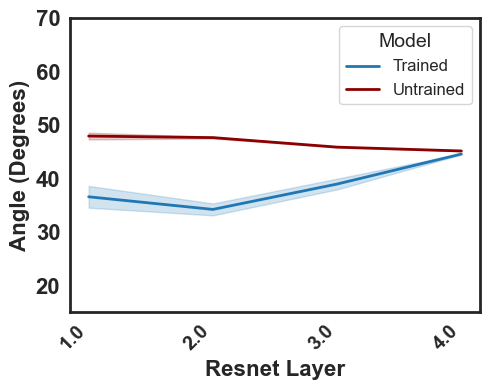

In [77]:
combined_angles_trained, combined_angles_untrained, svd_ev_trained_weight, svd_ev_untrained_weight, svd_ev_trained_activity, svd_ev_untrained_activity = process_results_ev(branching_downsample_results)
# print keys in angles_trained_dict
module_names = list(combined_angles_trained.keys())
print(module_names)

# get the nubmer of trained and untrained angles
trained_angles = [angle for angles in combined_angles_trained.values() for angle in angles]

# grab only from the 5th character onwards in the name
parsed_names = [name[5:] for name in module_names]
print(parsed_names)

title = 'Mean Subspace Angles Branching Connection'

plot_angle_lineplot(combined_angles_trained, combined_angles_untrained,  
                           parsed_names, palette, title, 
                           figsize=(5, 4), filepath=None, filename=None)